This notebook is a test to compare float grounding pressure with bathymetry products, on a specific region  
__author__ = 'kevin.balem@ifremer.fr'
Here's the 1st plan :
- Get float index
- Subset region of interest
- Get/Set floats url
- Xarray open if files exists, and preprocess at max
- Subset again region of interest
- Interp etopo at cycles positions
- Map both bathy and difference
- Stat it (deviationS, errors, ...)

In [122]:
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import scipy.interpolate as interpolate
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')
multibeam = xr.open_dataset('/export/home1/DATA/RREX_BATHY/caris_mb_001.grd')

In [6]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': np.str, 'profiler_type': np.str, 'institution': np.str}
                )
ix.tail()

,file,date,latitude,longitude,ocean,profiler_type,institution,update
2527166,nmdis/2901633/profiles/R2901633_067.nc,2.013050e+13,27.462000,139.106995,P,841,NM,20130507103443
2527167,nmdis/2901633/profiles/R2901633_068.nc,2.013051e+13,27.431999,138.839996,P,841,NM,20130511165723
2527168,nmdis/2901633/profiles/R2901633_069.nc,2.013052e+13,27.691999,138.677002,P,841,NM,20130521170139
2527169,nmdis/2901633/profiles/R2901633_070.nc,2.013053e+13,27.895000,138.464996,P,841,NM,20130531181516
2527170,nmdis/2901633/profiles/R2901633_071.nc,2.013061e+13,27.931000,138.089996,P,841,NM,20130617181801


In [14]:
print(multibeam.min())
print(multibeam.max())

lon      -36.2953
lat       55.8423
depth    437.5470
dtype: float64
lon       -29.457
lat        59.000
depth    4102.260
dtype: float64


In [131]:
roi = np.array([-34.7,-33.5,56.5,57.5])
ixs = ix[(ix['latitude']>roi[2])&(ix['latitude']<roi[3]) & 
         (ix['longitude']>roi[0])&(ix['longitude']<roi[1])&
         ((ix['profiler_type']=='838'))]
#         ((ix['profiler_type']=='844')|(ix['profiler_type']=='838'))]
ixs = ixs.reset_index().drop(columns='index')
ixs

,file,date,latitude,longitude,ocean,profiler_type,institution,update
0,coriolis/6901603/profiles/D6901603_001.nc,2.017081e+13,56.789001,-33.682999,A,838,IF,20210430154222
1,coriolis/6901603/profiles/D6901603_001D.nc,2.017081e+13,56.741001,-33.710999,A,838,IF,20210430154222
2,coriolis/6901603/profiles/D6901603_002.nc,2.017082e+13,56.888000,-33.773998,A,838,IF,20210430154222
3,coriolis/6901603/profiles/D6901603_003.nc,2.017083e+13,56.919998,-33.630001,A,838,IF,20210430154222
4,coriolis/6901603/profiles/D6901603_004.nc,2.017091e+13,56.992001,-33.722000,A,838,IF,20210430154222
5,coriolis/6901603/profiles/D6901603_005.nc,2.017092e+13,56.958000,-33.856998,A,838,IF,20210430154222
6,coriolis/6901603/profiles/D6901603_006.nc,2.017093e+13,57.000000,-33.641998,A,838,IF,20210430154222
7,coriolis/6901603/profiles/D6901603_007.nc,2.017101e+13,56.895000,-33.969002,A,838,IF,20210430154222
8,coriolis/6901603/profiles/D6901603_008.nc,2.017102e+13,56.780998,-33.987000,A,838,IF,20210430154222
9,coriolis/6901603/profiles/D6901603_009.nc,2.017103e+13,56.763000,-34.159000,A,838,IF,20210430154222


In [132]:
dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[f.split('/')[1] for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').max().reset_index()
ixs

,wmo,file,date,latitude,longitude,ocean,profiler_type,institution,update,dac
0,6901603,coriolis/6901603/profiles/D6901603_012.nc,2.017113e+13,57.000000,-33.630001,A,838,IF,20210430154222,coriolis
1,6902810,coriolis/6902810/profiles/D6902810_001D.nc,2.017081e+13,56.792999,-33.681999,A,838,IF,20210430093335,coriolis
2,6902881,coriolis/6902881/profiles/D6902881_001D.nc,2.018071e+13,56.799999,-34.171001,A,838,IF,20210503101732,coriolis
3,6902882,coriolis/6902882/profiles/D6902882_003.nc,2.018073e+13,56.798000,-34.173000,A,838,IF,20210430171822,coriolis


In [133]:
# MODE BOURRIN POUR LE MOMENT, à SKIPPER LES FLOTTEURS OU IL Y A UN SOUCIS
df = xr.Dataset({"LATITUDE":(["N_PROF"],[]),"LONGITUDE": (["N_PROF"],[]),"WMO": (["N_PROF"],[]),"Zg": (["N_PROF"],[]), "Zp": (["N_PROF"],[])},coords={})
for i in range(len(ixs)):    
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"   
    urld="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_prof.nc"
    if (os.path.exists(urlt)):
        try:
            dt = xr.open_dataset(urlt)        
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]
            try:
                grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]
            except KeyError:
                try:
                    grounded = dt['CYCLE_NUMBER_ACTUAL'].values[cycles_grounded]
                except KeyError:
                    grounded = []
        except:
            #print('issue on : '+urlt)
            pass
        if (len(grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()
                # GROUNDING DATE > PARKING DRIFT END ?
                # Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 300)
                park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
                a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_prf']==True,drop=True)
                
                dd = xr.open_dataset(urld)
                # PROFILE DATA
                ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,
                                                                dg['CYCLE_NUMBER'].values)])[['PRES','JULD','CYCLE_NUMBER',
                                                                                              'LATITUDE','LONGITUDE']].groupby('CYCLE_NUMBER').last()               
                # MAX PRES AND DEPTH CALCULATION for ds and dg
                ds = ds.max('N_LEVELS')
                ds['Z'] = -1*xr.DataArray(gsw.z_from_p(ds['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')                
                
                dtmp = xr.Dataset({"LATITUDE":("N_PROF",ds['LATITUDE'].values),
                                   "LONGITUDE":("N_PROF",ds['LONGITUDE'].values),
                                   "WMO":("N_PROF",np.zeros_like(ds['LONGITUDE'].values)+int(ixs['wmo'][i])),
                                   "Zg": ("N_PROF",dg['Z'].values),
                                   "Zp": ("N_PROF",ds['Z'].values)},coords={})
                    
                df=xr.concat([df,dtmp],dim='N_PROF')
            except:
                #print('issue on : '+urld) 
                pass

In [134]:
df = df.where((df['LONGITUDE']>roi[0])&(df['LONGITUDE']<roi[1])&(df['LATITUDE']>roi[2])&(df['LATITUDE']<roi[3]),drop=True)
df = df.sortby('LONGITUDE')
df

<xarray.Dataset>
Dimensions:    (N_PROF: 15)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float64 56.82 56.64 56.71 56.76 ... 56.79 57.0 56.92
    LONGITUDE  (N_PROF) float64 -34.53 -34.39 -34.36 ... -33.68 -33.64 -33.63
    WMO        (N_PROF) float64 6.902e+06 6.903e+06 ... 6.902e+06 6.902e+06
    Zg         (N_PROF) float64 2.128e+03 2.469e+03 ... 2.484e+03 2.374e+03
    Zp         (N_PROF) float64 2.119e+03 2.467e+03 ... 2.508e+03 2.366e+03

In [145]:
# SPREAD BATHY : Array of random points around position to interpolate bathy
from cartopy.geodesic import Geodesic

PTS=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                           lat=df['LATITUDE'].isel(N_PROF=i).values,
                                           radius=100.,
                                           n_samples=25.)) for i in range(len(df['N_PROF']))])

radius = 2000.0 #in meters
radrange  = np.linspace(200,radius,6)
for r in radrange:
    PT0=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                               lat=df['LATITUDE'].isel(N_PROF=i).values,
                                               radius=r,
                                               n_samples=50.)) for i in range(len(df['N_PROF']))])
    PTS = np.column_stack((PTS,PT0))

x=xr.DataArray(PTS[:,:,0],dims=['N_PROF','PTS'])
y=xr.DataArray(PTS[:,:,1],dims=['N_PROF','PTS'])
spread_bathy = xr.Dataset()
spread_bathy['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
spread_bathy['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
spread_bathy['multibeam'] = -1*multibeam.interp(x=x,y=y,method='linear')['z']
spread_bathy

<xarray.Dataset>
Dimensions:    (N_PROF: 15, PTS: 325)
Coordinates:
    x          (N_PROF, PTS) float64 -34.53 -34.53 -34.53 ... -33.62 -33.63
    y          (N_PROF, PTS) float64 56.82 56.82 56.82 ... 56.94 56.94 56.94
    lon        (N_PROF, PTS) float64 -34.53 -34.53 -34.53 ... -33.62 -33.63
    lat        (N_PROF, PTS) float64 56.82 56.82 56.82 ... 56.94 56.94 56.94
Dimensions without coordinates: N_PROF, PTS
Data variables:
    etopo      (N_PROF, PTS) float64 2.149e+03 2.149e+03 ... 2.146e+03 2.151e+03
    gebco      (N_PROF, PTS) float64 2.059e+03 2.057e+03 ... 2.492e+03 2.5e+03
    multibeam  (N_PROF, PTS) float64 2.094e+03 2.094e+03 ... 2.465e+03 2.502e+03

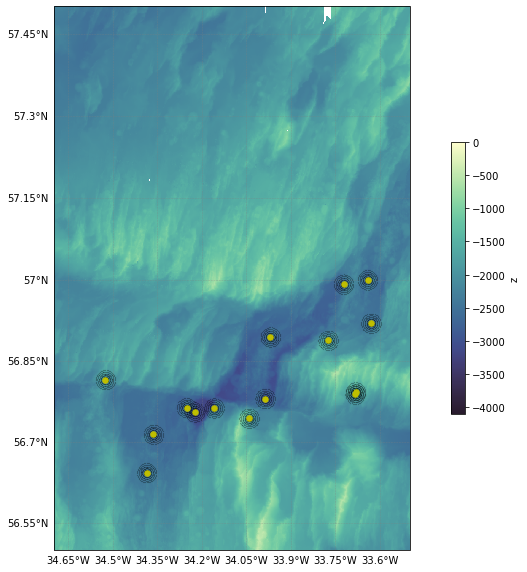

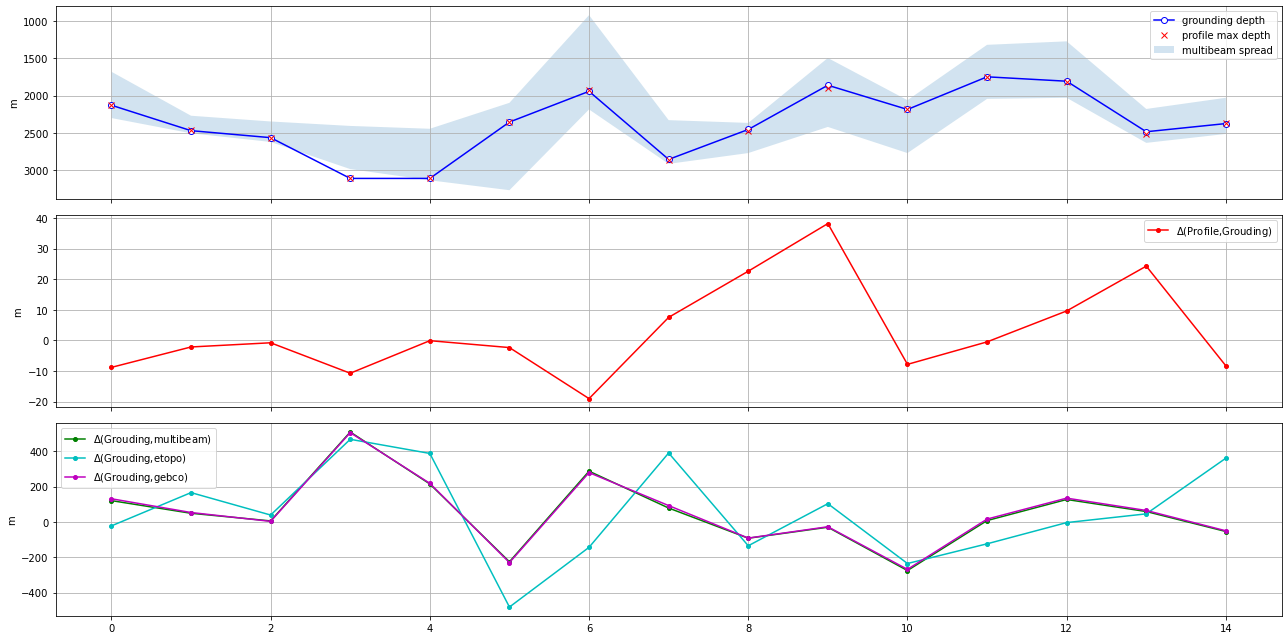

In [149]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

multibeam['z'].plot(vmax=0,cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())

ax.plot(spread_bathy['lon'],spread_bathy['lat'],'k.',markersize=0.2,transform=ccrs.PlateCarree())
ax.scatter(df['LONGITUDE'],df['LATITUDE'],s=30,c='y',transform=ccrs.PlateCarree(),zorder=100)

ax.set_extent(roi)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig, ax = plt.subplots(3,1,figsize=(18,9),sharex=True)

l=len(df['N_PROF'])

ax[0].invert_yaxis()
ax[0].plot(range(l),df['Zg'],"o-b",markerfacecolor='w',label='grounding depth')
ax[0].plot(range(l),df['Zp'],"xr",markerfacecolor='w',label='profile max depth')

ax[0].fill_between(range(l),spread_bathy['multibeam'].min('PTS'),spread_bathy['multibeam'].max('PTS'),alpha=0.2,label='multibeam spread')
ax[0].set_ylabel('m')
ax[0].legend()

ax[1].plot(range(l),df['Zp'].values-df['Zg'].values,"o-r",markersize=4,label=r'$\Delta$(Profile,Grouding)')

ax[1].set_ylabel('m')
ax[1].legend()

#ax[2].fill_between(range(l),df['Zg'].values - spread_bathy['multibeam'].min('PTS'),df['Zg'].values - spread_bathy['multibeam'].max('PTS'),alpha=0.2,label=r'$\Delta$(Grouding,multibeam spread)')
#ax[2].fill_between(range(l),df['Zg'].values - spread_bathy['etopo'].min('PTS'),df['Zg'].values - spread_bathy['etopo'].max('PTS'),alpha=0.2,label=r'$\Delta$(Grouding,etopo spread)')
#ax[2].fill_between(range(l),df['Zg'].values - spread_bathy['gebco'].min('PTS'),df['Zg'].values - spread_bathy['gebco'].max('PTS'),alpha=0.2,label=r'$\Delta$(Grouding,gebco spread)')

ax[2].plot(range(l),df['Zg'].values - spread_bathy['multibeam'].mean('PTS'),"o-g",markersize=4,label=r'$\Delta$(Grouding,multibeam)')
ax[2].plot(range(l),df['Zg'].values - spread_bathy['etopo'].mean('PTS'),"o-c",markersize=4,label=r'$\Delta$(Grouding,etopo)')
ax[2].plot(range(l),df['Zg'].values - spread_bathy['gebco'].mean('PTS'),"o-m",markersize=4,label=r'$\Delta$(Grouding,gebco)')

ax[2].set_ylabel('m')
ax[2].legend()

plt.tight_layout()